In [19]:
import pandas as pd

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('../Covid_19 Project/Data1.csv')

# Print the data types of each column
print(df.dtypes)


uuid                object
zcr                 object
energy              object
energy_entropy      object
centroid            object
                     ...  
delta chroma_10     object
delta chroma_11     object
delta chroma_12     object
delta chroma_std    object
status              object
Length: 70, dtype: object


In [48]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Read the CSV file


# Get the number of rows and columns
num_rows, num_cols = df.shape

# Create a 3D numpy array to store the data
data = np.zeros((num_rows, num_cols-2, 24))

# Loop through each row and column of the DataFrame
for i in range(num_rows):
    for j in range(1, num_cols-1):
        values = df.iloc[i, j]
        values = values.replace('[', '').replace(']', '').split(', ')
        values = [float(v) for v in values]
        # Pad the sequence with zeros to make it length 24
        padded_values = np.zeros(24)
        padded_values[:len(values)] = values
        data[i, j-1, :] = padded_values

# Reshape the data to a 3D matrix
data = data.reshape((num_rows, -1, 24))

output = df.iloc[:, -1].values

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(output)





In [23]:
import numpy as np
def NormalizeData(dt):
    return (dt - np.min(dt)) / (np.max(dt) - np.min(dt))
X = np.array(data)
scaled_x = NormalizeData(X)
print(X)

[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.72570391e-02
    1.72570391e-02  1.08991826e-02]
  [ 8.52910638e-08  8.42965479e-08  8.53970782e-08 ...  1.53510991e-01
    1.12715717e-01  9.80484802e-02]
  [ 3.30350133e+00  3.30546233e+00  3.30716201e+00 ...  3.01409526e+00
    3.06913192e+00  2.96613559e+00]
  ...
  [ 0.00000000e+00  2.03018614e-04 -1.78968167e-04 ... -1.65147110e-02
    1.99084071e-04  1.10287636e-02]
  [ 0.00000000e+00  9.26627820e-07 -3.42162037e-06 ... -2.60766016e-04
   -2.21829589e-04 -5.31758657e-05]
  [ 0.00000000e+00 -3.65711942e-04  4.83710121e-04 ...  1.73522835e-02
    3.36094410e-03 -6.81612408e-03]]

 [[ 2.54314260e-02  4.90463215e-02  7.26612171e-02 ...  5.81289737e-02
    6.08537693e-02  6.26702997e-02]
  [ 7.80553356e-02  1.29357895e-02  1.78263427e-02 ...  1.28313990e-01
    1.02308825e-01  6.11174182e-02]
  [ 2.57970566e+00  3.24221658e+00  3.19008024e+00 ...  3.19287133e+00
    3.21736096e+00  2.82665277e+00]
  ...
  [ 0.00000000e+00 -1.0

In [57]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Transpose the input data
x = np.transpose(data, axes=(0, 2, 1))

# Reshape the output data to have a single column and flatten it
y = labels_encoded.reshape((-1,))
y = y.ravel()  # Alternatively, you can use y.flatten()

# Use label encoding to convert the categorical labels to integer labels


# Use one-hot encoding to convert the integer labels to binary vectors

# Print the shapes of the input and output data
print('Input shape:', x.shape)
print('Output shape:', y.shape)


Input shape: (909, 24, 68)
Output shape: (909,)


In [65]:
from keras.layers import Dropout, BatchNormalization
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Permute, Multiply, Lambda, Reshape
import keras.backend as K

# Input shape
input_shape = (24, 68)  # Sequence length: 24, Number of features: 68

# Define the input layer
inputs = Input(shape=input_shape)

# LSTM layers
lstm_out = LSTM(68, return_sequences=True)(inputs)
lstm_out = LSTM(136, return_sequences=True)(lstm_out)
lstm_out = LSTM(68, return_sequences=True)(lstm_out)
lstm_out = LSTM(34, return_sequences=True)(lstm_out)
lstm_out = LSTM(17, return_sequences=True)(lstm_out)
lstm_out = LSTM(34, return_sequences=True)(lstm_out)

# Additional layers
lstm_out = Dropout(0.5)(lstm_out)
lstm_out = BatchNormalization()(lstm_out)

# Attention mechanism
attention = Dense(1, activation='tanh')(lstm_out)
attention = Permute([2, 1])(attention)
attention = Reshape((-1, 1))(attention)
attention = Multiply()([lstm_out, attention])
attention = Lambda(lambda x: K.sum(x, axis=1), output_shape=(34,))(attention)

# Additional layers after attention
attention = Dense(34, activation='relu')(attention)
attention = Dropout(0.5)(attention)

# Output layer
outputs = Dense(1, activation='sigmoid')(attention)  # Changed activation to 'sigmoid'

# Model creation
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 24, 68)]     0           []                               
                                                                                                  
 lstm_38 (LSTM)                 (None, 24, 68)       37264       ['input_10[0][0]']               
                                                                                                  
 lstm_39 (LSTM)                 (None, 24, 136)      111520      ['lstm_38[0][0]']                
                                                                                                  
 lstm_40 (LSTM)                 (None, 24, 68)       55760       ['lstm_39[0][0]']                
                                                                                            

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 24, 68)]     0           []                               
                                                                                                  
 lstm_50 (LSTM)                 (None, 24, 128)      100864      ['input_12[0][0]']               
                                                                                                  
 lstm_51 (LSTM)                 (None, 24, 64)       49408       ['lstm_50[0][0]']                
                                                                                                  
 lstm_52 (LSTM)                 (None, 24, 32)       12416       ['lstm_51[0][0]']                
                                                                                           

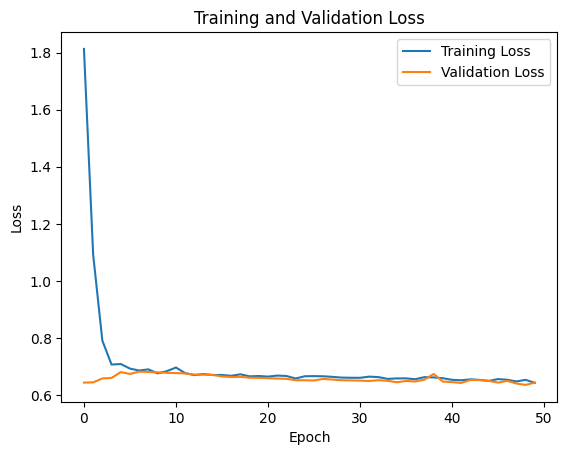

6/6 [==============================] - 1s 35ms/step


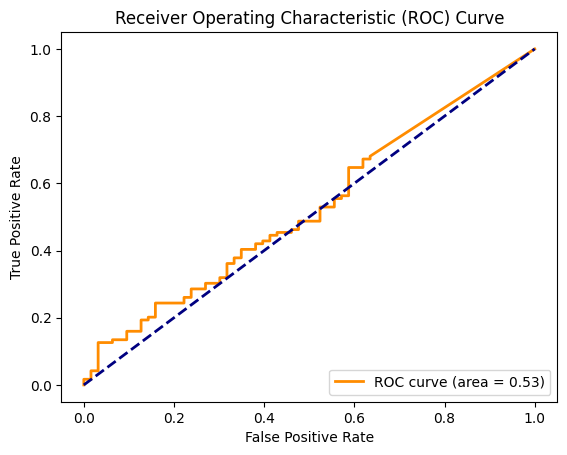

In [69]:
from keras.layers import Dropout, BatchNormalization
import numpy as np
from keras.models import Model
from keras import backend as K
from keras.layers import Input, LSTM, Dense, Permute, Multiply, Lambda, Reshape
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define the input shape
input_shape = (24, 68)

# Define the input layer
inputs = Input(shape=input_shape)

# LSTM layers
lstm_out = LSTM(128, return_sequences=True)(inputs)
lstm_out = LSTM(64, return_sequences=True)(lstm_out)
lstm_out = LSTM(32, return_sequences=True)(lstm_out)

# Additional layers
lstm_out = Dropout(0.5)(lstm_out)
lstm_out = BatchNormalization()(lstm_out)

# Attention mechanism
attention = Dense(1, activation='tanh')(lstm_out)
attention = Permute([2, 1])(attention)
attention = Reshape((-1, 1))(attention)
attention = Multiply()([lstm_out, attention])
attention = Lambda(lambda x: K.sum(x, axis=1), output_shape=(64,))(attention)

# Additional layers after attention
attention = Dense(32, activation='relu')(attention)
attention = Dropout(0.5)(attention)

# Output layer
outputs = Dense(1, activation='sigmoid')(attention)

# Model creation
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

# Evaluate the model on test data
loss, accuracy = model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot ROC curve
predictions = model.predict(x_test)
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [70]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Make predictions on test data
predictions = model.predict(x_test)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert one-hot encoded true labels to class labels
true_labels = np.argmax(y_test, axis=1)

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print('Confusion Matrix:')
print(conf_matrix)

# Calculate precision, recall, and F1-score
from sklearn.metrics import classification_report
print('Classification Report:')
print(classification_report(true_labels, predicted_labels))



6/6 [==============================] - 0s 35ms/step


AxisError: axis 1 is out of bounds for array of dimension 1